In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

import MetaTrader5 as mt5
import pytz

from IPython.display import display, display_markdown

### MT5を利用してUSDJPYの日足データを取得する(2000/01/01~2020/12/31)

In [2]:
# connect to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()

# set time zone to UTC
timezone = pytz.utc

# create 'datetime' objects in UTC time zone to avoid the implementation of a local time zone offset
utc_from = datetime(2000, 1, 1, tzinfo=timezone)
utc_to = datetime(2021, 1, 1, tzinfo=timezone)
 
rates = mt5.copy_rates_range("USDJPY", mt5.TIMEFRAME_D1, utc_from, utc_to)
rates_frame = pd.DataFrame(rates)

# convert time in seconds into the datetime format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')

# shut down connection to the MetaTrader 5 terminal
mt5.shutdown()

# display data
rates_frame.head(10)

,time,open,high,low,close,tick_volume,spread,real_volume
0,2000-01-03,102.14,102.26,101.39,101.68,4498,50,0
1,2000-01-04,101.71,103.34,101.50,103.15,6780,50,0
2,2000-01-05,103.16,104.47,102.80,104.12,5860,50,0
3,2000-01-06,104.12,105.58,103.98,105.26,6729,50,0
4,2000-01-07,105.26,105.92,104.87,105.41,5457,50,0
5,2000-01-10,105.11,105.39,104.33,105.17,5557,50,0
6,2000-01-11,105.16,106.33,105.09,106.05,6932,50,0
7,2000-01-12,106.04,106.27,105.54,105.73,6353,50,0
8,2000-01-13,105.73,106.25,105.42,106.10,5631,50,0
9,2000-01-14,106.08,106.60,105.46,105.93,5457,50,0


## CUSUMフィルタ

In [3]:
def getTEvents(gRaw, h):
    '''
    本書のサンプルコード
    '''
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i]), min(0, sNeg + diff.loc[i])
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
    
    return pd.DatetimeIndex(tEvents)

In [4]:
price_daily = rates_frame.copy()

In [5]:
price_daily['R'] = price_daily['close'].diff() / price_daily['close']
price_daily.dropna(subset=['R'], inplace=True)
price_daily.set_index('time', inplace=True)
price_daily.head()

,open,high,low,close,tick_volume,spread,real_volume,R
time,,,,,,,,
2000-01-04,101.71,103.34,101.50,103.15,6780,50,0,0.014251
2000-01-05,103.16,104.47,102.80,104.12,5860,50,0,0.009316
2000-01-06,104.12,105.58,103.98,105.26,6729,50,0,0.010830
2000-01-07,105.26,105.92,104.87,105.41,5457,50,0,0.001423
2000-01-10,105.11,105.39,104.33,105.17,5557,50,0,-0.002282


In [6]:
h = 0.025
t_events = getTEvents(price_daily['R'], h)
print(len(t_events))

246


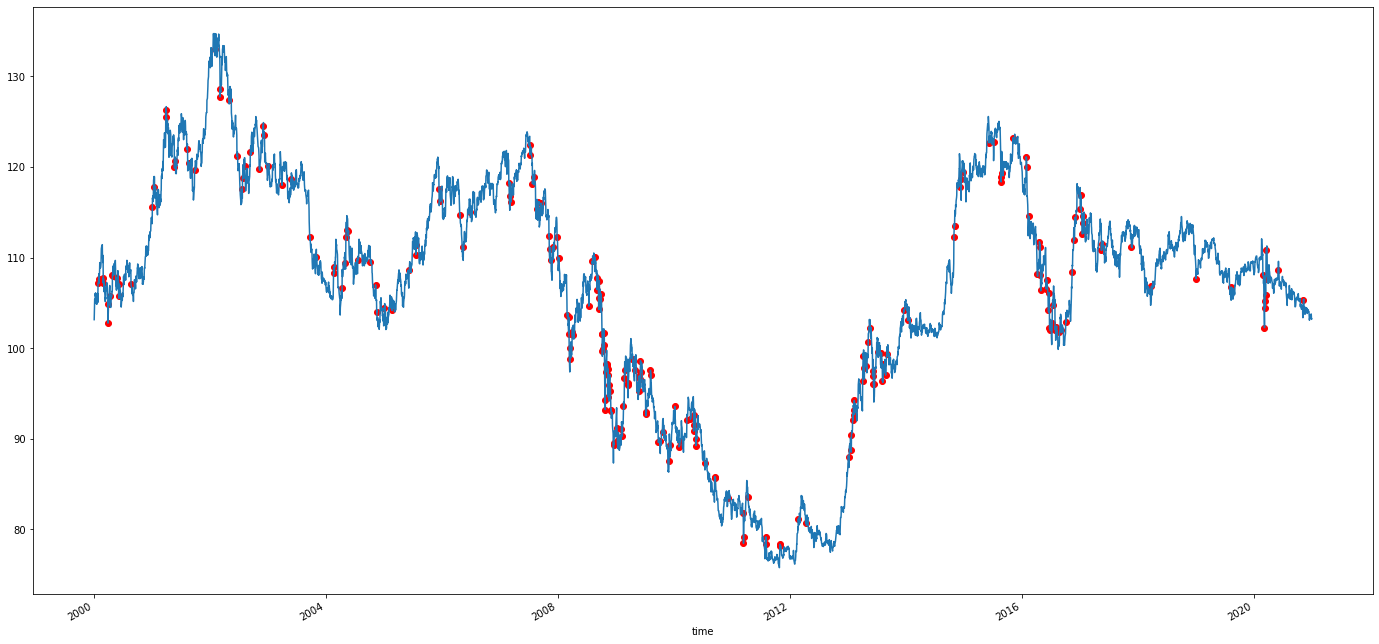

In [7]:
plt.figure(figsize=(24, 12))
price_daily['close'].plot()
plt.scatter(x=t_events, y=price_daily.loc[t_events, ['close']], color='red')

In [8]:
price_daily_ds = price_daily.loc[t_events].copy()
price_daily_ds.head()

,open,high,low,close,tick_volume,spread,real_volume,R
2000-01-28,105.06,107.27,104.55,107.19,6233,50,0,0.019871
2000-02-03,108.20,108.78,107.17,107.59,6486,50,0,-0.005763
2000-03-01,110.20,110.25,106.55,107.19,7488,50,0,-0.028454
2000-03-02,107.19,107.95,106.56,107.72,8185,50,0,0.004920
2000-03-31,105.47,106.08,102.03,102.77,8199,50,0,-0.026078


In [9]:
price_daily_ds['R'] = price_daily_ds['close'].diff() / price_daily_ds['close']

<AxesSubplot:>

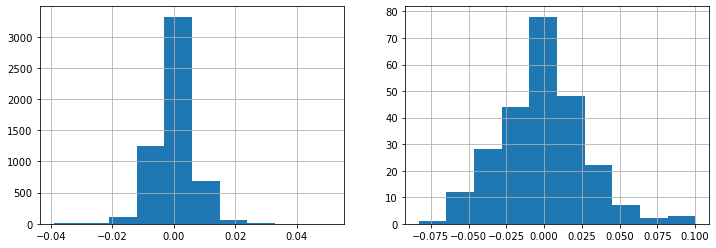

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
price_daily['R'].hist()

plt.subplot(1, 2, 2)
price_daily_ds['R'].hist()

In [11]:
print("Skewness(歪度), Kurtosis(尖度)")
print("Daily :", price_daily['R'].skew(), price_daily['R'].kurt())
print("Down Sampling :", price_daily_ds['R'].skew(), price_daily_ds['R'].kurt())

Skewness(歪度), Kurtosis(尖度)
Daily : -0.14754557187883918 4.3650895171594035
Down Sampling : 0.2114892825778588 0.9959342122183918


正規分布に近づいた